# Variational Autoencoder: LeNet-5 CNN with PyTorch and MNIST

[Reference](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/1_VAE_mnist_sigmoid_mse.ipynb) and [Second reference](https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L17/helper_train.py)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/arjun/anaconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(f"torch version: {torch.__version__}")

torch version: 1.11.0


In [4]:
# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080


In [5]:
# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

Available device is cuda


In [6]:
# Hyper-parameters-
num_epochs = 60
batch_size = 256
learning_rate = 0.001

### MNIST data pre-processing:

#### Compute mean and standard deviation for different datasets

```
import argparse
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

dataset_names = ('cifar10','cifar100','mnist')

parser = argparse.ArgumentParser(description='PyTorchLab')
parser.add_argument('-d', '--dataset', metavar='DATA', default='cifar10', choices=dataset_names,
                    help='dataset to be used: ' + ' | '.join(dataset_names) + ' (default: cifar10)')

args = parser.parse_args()

data_dir = os.path.join('.', args.dataset)

print(args.dataset)

if args.dataset == "cifar10":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(train_set.train_data.mean(axis=(0,1,2))/255)
    print(train_set.train_data.std(axis=(0,1,2))/255)

elif args.dataset == "cifar100":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.CIFAR100(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(train_set.train_data.shape)
    print(np.mean(train_set.train_data, axis=(0,1,2))/255)
    print(np.std(train_set.train_data, axis=(0,1,2))/255)

elif args.dataset == "mnist":
    train_transform = transforms.Compose([transforms.ToTensor()])
    train_set = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=train_transform)
    #print(vars(train_set))
    print(list(train_set.train_data.size()))
    print(train_set.train_data.float().mean()/255)
    print(train_set.train_data.float().std()/255)
```

[Reference](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/11)

In [7]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [8]:
# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = './data', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = './data', train = False,
        transform = transforms_apply
        )

In [9]:
# Sanity check-
print(f"training dataset length/shape: {list(train_dataset.data.size())}")

training dataset length/shape: [60000, 28, 28]


In [10]:
print(f"mean = {train_dataset.data.float().mean() / 255:.4f}")

mean = 0.1307


In [11]:
print(f"std dev = {train_dataset.data.float().std() / 255:.4f}")

std dev = 0.3081


#### NOTE:

Since MNIST has only one channel, therefore, the mean and standard deviation is computed for one channel!

In [12]:
# Sanity check-
train_dataset.data.min(), train_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [13]:
test_dataset.data.min(), test_dataset.data.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

#### Scale pixel values in the range 0 to 1

To manually convert the pixel values in the range 0 to 1.

In [14]:
train = train_dataset.data.float() / 255.0
test = test_dataset.data.float() / 255.0

In [15]:
type(train), type(test)

(torch.Tensor, torch.Tensor)

In [16]:
train.shape, test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [17]:
# Reshape to include gray-scale channel-
train = train.reshape(60000, 1, 28, 28)
test = test.reshape(10000, 1, 28, 28)

In [18]:
train.shape, test.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

In [19]:
# Sanity check- min and max pixel values are in the range 0 to 1-
train.data.min(), train.data.max()

(tensor(0.), tensor(1.))

In [20]:
test.data.min(), test.data.max()

(tensor(0.), tensor(1.))

In [21]:
del train_dataset, test_dataset

In [22]:
print(f"batch size to be used = {batch_size}")

batch size to be used = 256


In [23]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
        dataset = train, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test, batch_size = batch_size,
        shuffle = False
        )

In [24]:
print(f"Sizes of train_dataset: {len(train)} and test_dataet: {len(test)}")
print(f"Sizes of train_loader: {len(train_loader)} and test_loader: {len(test_loader)}")

Sizes of train_dataset: 60000 and test_dataet: 10000
Sizes of train_loader: 235 and test_loader: 40


In [25]:
print(f"len(train_loader) = {len(train_loader)} & len(test_loader) = {len(test_loader)}")

len(train_loader) = 235 & len(test_loader) = 40


In [26]:
# Sanity check-
len(train) / batch_size, len(test) / batch_size

(234.375, 39.0625)

In [27]:
# Get some random batch of training images & labels-
# images, labels = next(iter(train_loader))
images = next(iter(train_loader))

# You get 64 images due to the specified batch size-
# print(f"images.shape: {images.shape} & labels.shape: {labels.shape}")
print(f"images.shape: {images.shape}")

images.shape: torch.Size([256, 1, 28, 28])


In [28]:
images.min(), images.max()

(tensor(0.), tensor(1.))

In [29]:
# De-normalize the batch of images-
images *= 255.0

In [30]:
images.min(), images.max()

(tensor(0.), tensor(255.))

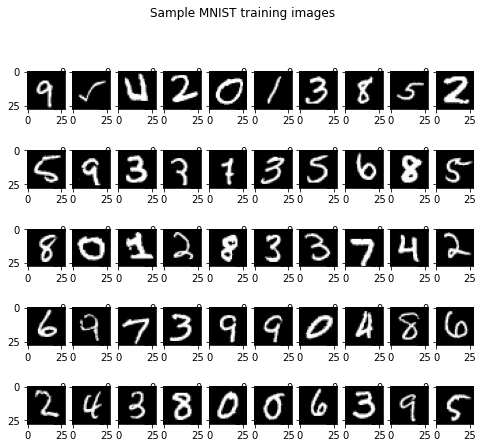

In [31]:
# Visualize 10 images from training set-
plt.figure(figsize = (8, 7))
for i in range(50):
    # 4 rows & 5 columns-
    plt.subplot(5, 10, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(images[i][0], cmap = 'gray')
    
plt.suptitle("Sample MNIST training images")
plt.show()

### Define Variational Autoencoder architecture using _convolutional_ layers

In [32]:
class LeNet_Encoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Encoder, self).__init__()
        
        self.latent_space = latent_space
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6,
            kernel_size = 3, stride = 2,
            padding = 1, bias = True
        )
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv3 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.conv4 = nn.Conv2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = True
        )
        self.dense = nn.Linear(
            in_features = 64, out_features = 10,
            bias = True
        )
        '''
        self.dense2 = nn.Linear(
            in_features = 30, out_features = 10,
            bias = True
        )
        '''
        self.encoder_output = nn.Linear(
            in_features = 10, out_features = self.latent_space,
            bias = True
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        # print(f"before flatten, x.shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        x = F.leaky_relu(self.dense(x))
        # x = F.leaky_relu(self.dense2(x))
        x = F.leaky_relu(self.encoder_output(x))
        return x
        
        
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"conv1 output shape: {x.shape}")
        x = self.conv2(x)
        print(f"conv2 output shape: {x.shape}")
        x = self.conv3(x)
        print(f"conv3 output shape: {x.shape}")
        x = self.conv4(x)
        print(f"conv4 output shape: {x.shape}")
        x = torch.flatten(x, start_dim = 1)
        print(f"flattened shape: {x.shape}")
        x = self.dense(x)
        print(f"dense output shape: {x.shape}")
        # x = self.dense2(x)
        # print(f"dense2 output shape: {x.shape}")
        x = self.encoder_output(x)
        print(f"encoder output shape: {x.shape}")
        del x
        return None
        

In [33]:
class LeNet_Decoder(nn.Module):
    def __init__(self, latent_space):
        super(LeNet_Decoder, self).__init__()
        
        self.latent_space = latent_space
        self.dense_layer1 = nn.Linear(
            in_features = self.latent_space, out_features = 10,
            bias = True
        )
        
        self.dense_layer2 = nn.Linear(
            in_features = 10, out_features = 64,
            bias = True
        )
        '''
        self.dense_layer3 = nn.Linear(
            in_features = 30, out_features = 64,
            bias = True
        )
        '''
        self.conv_tran_layer1 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer2 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.conv_tran_layer3 = nn.ConvTranspose2d(
            in_channels = 16, out_channels = 6,
            kernel_size = 5, stride = 1,
            padding = 0
        )
        self.op_conv_tran_layer = nn.ConvTranspose2d(
            in_channels = 6, out_channels = 1,
            kernel_size = 2, stride = 2,
            padding = 0
        )
        
        self.initialize_weights()
        
    
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
        
        
    def forward(self, x):
        x = F.leaky_relu(self.dense_layer1(x))
        x = F.leaky_relu(self.dense_layer2(x))
        # x = F.leaky_relu(self.dense_layer3(x))
        x = x.view(-1, 16, 2, 2)
        x = F.leaky_relu(self.conv_tran_layer1(x))
        x = F.leaky_relu(self.conv_tran_layer2(x))
        x = F.leaky_relu(self.conv_tran_layer3(x))
        x = self.op_conv_tran_layer(x)
        return x
 

    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.dense_layer1(x)
        print(f"dense1 output shape: {x.shape}")
        x = self.dense_layer2(x)
        print(f"dense2 output shape: {x.shape}")
        # x = self.dense_layer3(x)
        # print(f"dense3 output shape: {x.shape}")
        x = x.view(-1, 16, 2, 2)
        print(f"reshaped output shape: {x.shape}")
        x = self.conv_tran_layer1(x)
        print(f"conv transpose1 output shape: {x.shape}")
        x = self.conv_tran_layer2(x)
        print(f"conv transpose2 output shape: {x.shape}")
        x = self.conv_tran_layer3(x)
        print(f"conv transpose3 output shape: {x.shape}")
        x = self.op_conv_tran_layer(x)
        print(f"decoder output shape: {x.shape}")
        del x
        return None


In [34]:
class VAE_Conv(nn.Module):
    def __init__(self, latent_space = 5):
        super(VAE_Conv, self).__init__()
        
        self.latent_space = latent_space
        
        # Encoder-
        self.encoder = LeNet_Encoder(latent_space = self.latent_space).to(device)
        
        # Two additional layers 'mu' & 'log_var' to convert the bottleneck into the μ and σ vectors-
        self.mu = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        self.log_var = nn.Linear(
            in_features = self.latent_space, out_features = self.latent_space,
            bias = True
        )
        
        # Decoder-
        self.decoder = LeNet_Decoder(latent_space = self.latent_space).to(device)
        
        
    def reparameterize(self, mu, log_var):
        '''
        Input arguments:
        1. mu - mean coming from the encoder's latent space
        2. log_var - log variance coming from the encoder's latent space
        '''
        # Compute standard deviation using 'log_var'-
        std = torch.exp(0.5 * log_var)
        
        # 'eps' samples from a normal standard distribution to add
        # stochasticity to the sampling process-
        eps = torch.randn_like(std)
        
        # Reparameterization trick - sample as if it's from the input
        # space-
        z = mu + (std * eps)
        
        return z
    
    
    def forward(self, x):
        # Encode input data-
        x = self.encoder(x)
        # NOTE: The line of code above does NOT give us the latent vector!
        
        mu = self.mu(x)
        log_var = self.log_var(x)
        
        # Obtain the latent vector using reparameterization-
        z = self.reparameterize(mu, log_var)
        # latent vector 'z' is obtained through reparameterization trick using mu and log_var
        
        # Decode latent vector-
        recon_data = torch.sigmoid(self.decoder(z))
        # recon_data = torch.tanh(self.decoder(z))
        
        return recon_data, mu, log_var
    
    
    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.encoder(x)
        print(f"Encoder output shape: {x.shape}")
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        print(f"mu.shape: {mu.shape}, log_var.shape: {log_var.shape}"
              f" & z.shape: {z.shape}")
        x = self.decoder(z)
        print(f"Decoder output shape: {x.shape}")
        del x, mu, log_var, z
        return None
    
    

In [35]:
# Initialize a VAE objetc-
model = VAE_Conv(latent_space = 3).to(device)

In [ ]:
# print(model)

In [36]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

layer.shape = torch.Size([6, 1, 3, 3]) has 54 parameters
layer.shape = torch.Size([6]) has 6 parameters
layer.shape = torch.Size([16, 6, 5, 5]) has 2400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 16, 5, 5]) has 6400 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([10, 64]) has 640 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([3, 10]) has 30 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([3, 3]) has 9 parameters
layer.shape = torch.Size([3]) has 3 parameters
layer.shape = torch.Size([10, 3]) has 30 parameters
layer.shape = torch.Size([10]) has 10 parameters
layer.shape = torch.Size([64, 10]) has 640 parameters
layer.shape = to

In [37]:
print(f"Total number of parameters in VAE Conv model = {tot_params}")

Total number of parameters in VAE Conv model = 32022


### Initial variance - Sanity check:

Before training the VAE neural network model, there should be some initial variance.

In [40]:
for x in model.mu.parameters():
    print(x.shape, x.nelement())

torch.Size([3, 3]) 9
torch.Size([3]) 3


In [41]:
log_var_wts = model.log_var.weight
mu_wts = model.mu.weight

In [42]:
mu_wts = mu_wts.detach().cpu().numpy()
log_var_wts = log_var_wts.detach().cpu().numpy()

In [43]:
mu_wts.shape, log_var_wts.shape

((3, 3), (3, 3))

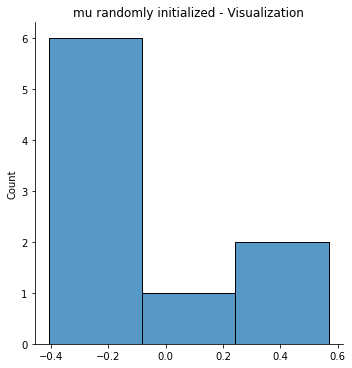

In [44]:
sns.displot(data = mu_wts.flatten(), bins = int(np.ceil(np.sqrt(mu_wts.size))))
plt.title("mu randomly initialized - Visualization")
plt.show()

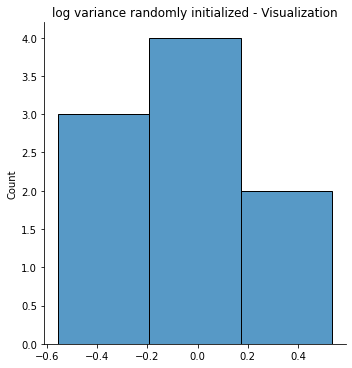

In [45]:
sns.displot(data = log_var_wts.flatten(), bins = int(np.ceil(np.sqrt(log_var_wts.size))))
plt.title("log variance randomly initialized - Visualization")
plt.show()

In [46]:
del mu_wts, log_var_wts

In [47]:
images = images.to(device)

In [48]:
images.shape

torch.Size([256, 1, 28, 28])

In [49]:
images.min(), images.max()

(tensor(0., device='cuda:0'), tensor(255., device='cuda:0'))

In [50]:
# Sanity check-
recon_images, mu, log_var = model(images)

In [51]:
recon_images.shape, mu.shape, log_var.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 3]), torch.Size([256, 3]))

In [52]:
recon_images.min().detach().cpu().numpy(), recon_images.max().detach().cpu().numpy()

(array(0., dtype=float32), array(1., dtype=float32))

In [53]:
del recon_images, mu, log_var

In [38]:
print(f"Adam optimizer with learning rate = {learning_rate} will be used")

Adam optimizer with learning rate = 0.001 will be used


In [39]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 5e-4)

In [40]:
def total_loss(data, data_recon, mu, log_var, alpha = 1, beta = 1):
    '''
    Function to compute loss = reconstruction loss * reconstruction_term_weight + KL-Divergence loss.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    
    Inputs:
    1. mu: mean from the latent vector
    2. logvar: log variance from the latent vector
    3. alpha (int): Hyperparameter to control the importance of reconstruction
    loss vs KL-Divergence Loss - reconstruction term weight
    4. data: training data
    5. data_recon: VAE's reconstructed data
    '''
    
    # Sum over latent dimensions-
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var), axis = 1)
    # kl_div = -0.5 * torch.sum(1 + log_var - (mu **2) - torch.exp(log_var), axis = 1)
    
    # kl_div.shape
    # torch.Size([32])
    
    batchsize = kl_div.size(0)

    # Average over batch dimension-
    kl_div = kl_div.mean()
    
    reconstruction_loss_fn = F.mse_loss
    recon_loss = reconstruction_loss_fn(data_recon, data, reduction = 'none')
    
    # recon_loss.shape
    # torch.Size([32, 1, 28, 28])
    
    # Sum over all pixels-
    recon_loss = recon_loss.view(batchsize, -1).sum(axis = 1)
    
    # recon_loss.shape
    # torch.Size([32])
    
    # Average over mini-batch dimension-
    recon_loss = recon_loss.mean()
    
    final_loss = (alpha * recon_loss) + (beta * kl_div)
    
    return final_loss, recon_loss, kl_div


In [ ]:
'''
# Sanity check-
final_loss, recon_loss, kl_div_loss = total_loss(
    data = images, data_recon = recon_images,
    mu = mu, log_var = log_var,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
print(f"final loss = {final_loss.cpu().detach().numpy():.4f},"
      f" reconstruction loss = {recon_loss.cpu().detach().numpy():.4f}"
      f" & kl-div loss = {kl_div_loss.cpu().detach().numpy():.4f}"
     )
'''

In [43]:
def train_one_epoch(model, dataloader, alpha, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to keep track of 3 losses-
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    
    for i, data in tqdm(
        enumerate(dataloader),
        # total = int(len(train_dataset) / dataloader.batch_size)
        total = int(len(train) / dataloader.batch_size)
        ):
      
        # Ignore labels-
        # data, _ = data

        # Push data points to 'device'-
        data = data.to(device)
        
        # Flatten input data to feed into a dense layer-
        # data = data.view(data.size(0), -1)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()
        
        # Perform forward propagation-
        recon_data, mu, logvar = model(data)
        
        final_loss, recon_loss, kl_div_loss = total_loss(
            data = data, data_recon = recon_data,
            mu = mu, log_var = logvar,
            alpha = alpha, beta = beta
        )
        
        # Update losses-
        running_final_loss += final_loss.item()
        running_kl_loss += kl_div_loss.cpu().detach().numpy()
        running_recon_loss += recon_loss.cpu().detach().numpy()
        
        # Compute gradients wrt total loss-
        final_loss.backward()
        
        # Perform gradient descent-
        optimizer.step()
    
    # Compute losses as float values-
    train_loss = running_final_loss / len(dataloader.dataset)
    kl_loss = running_kl_loss / len(dataloader.dataset)
    recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return train_loss, kl_loss, recon_loss


In [44]:
def validate_one_epoch(model, dataloader, alpha, beta):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_final_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            # total = int(len(test_dataset) / dataloader.batch_size)):
            total = int(len(test) / test_loader.batch_size)):
          
            # Ignore labels-
            # data, _ = data

            # Push data points to 'device'-
            data = data.to(device)
            
            # Flatten data to feed into a dense layer-
            # data = data.view(data.size(0), -1)
            
            # Forward propagation-
            recon_data, mu, logvar = model(data)
            
            final_loss, recon_loss, kl_div_loss = total_loss(
                data = data, data_recon = recon_data,
                mu = mu, log_var = logvar,
                alpha = alpha, beta = beta
            )
        
            # Update losses-
            running_final_loss += final_loss.item()
            running_kl_loss += kl_div_loss.cpu().detach().numpy()
            running_recon_loss += recon_loss.cpu().detach().numpy()
            
                
    val_loss = running_final_loss / len(dataloader.dataset)
    val_kl_loss = running_kl_loss / len(dataloader.dataset)
    val_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return val_loss, val_kl_loss, val_recon_loss

    

In [ ]:
'''
# Sanity check-
train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
    model = model, dataloader = train_loader,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
    model = model, dataloader = test_loader,
    alpha = 1, beta = 1
)
'''

In [ ]:
'''
print(f"After one epoch: train loss = {train_loss:.4f}, recon loss = {recon_train_loss:.4f}"
      f" & kl-div loss = {kl_train_loss:.4f}"
     )
'''

In [ ]:
'''
print(f"After one epoch: val train loss = {val_loss:.4f}, val recon loss = {val_recon_loss:.4f}"
      f" & val kl-div loss = {val_kl_loss:.4f}"
     )
'''

### Train VAE model 

In [45]:
# Specify alpha - Hyperparameter to control the importance of reconstruction
# loss vs KL-Divergence Loss-
alpha = 1
beta = 1

In [46]:
# Python dict to contain training metrics-
train_history = {}

In [47]:
print(f"Training VAE model for {num_epochs} epochs")

Training VAE model for 60 epochs


In [48]:
# Initialize parameters for Early Stopping manual implementation-
best_val_loss = 10000
# loc_patience = 0

In [ ]:
# User input parameters for Early Stopping in manual implementation-
# minimum_delta = 0.001
# patience = 3

In [50]:
for epoch in range(1, num_epochs + 1):
    '''
    # Manual early stopping implementation-
    if loc_patience >= patience:
        print("\n'EarlyStopping' called!\n")
        break
    '''
    
    # Train model for 1 epoch-
    train_loss, kl_train_loss, recon_train_loss = train_one_epoch(
        model = model, dataloader = train_loader,
        alpha = alpha, beta = beta
    )
    
    # Get validation after 1 epoch-
    val_loss, val_kl_loss, val_recon_loss = validate_one_epoch(
        model = model, dataloader = test_loader,
        alpha = alpha, beta = beta
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss,
        'train_recon_loss': kl_train_loss,
        'train_kl_loss': kl_train_loss,
        'val_loss': val_loss,
        'val_recon_loss': val_recon_loss,
        'val_kl_loss': val_kl_loss
    }
    
    print(f"Epoch = {epoch}; train loss = {train_loss:.4f}",
          f", kl-loss = {kl_train_loss:.4f}, recon loss = {recon_train_loss:.4f}",
          f", val loss = {val_loss:.4f}, val kl-loss = {val_kl_loss:.4f}",
          f" & val recon loss = {val_recon_loss:.4f}"
         )
    
    
    # Code for manual Early Stopping:
    if (val_loss < best_val_loss):
    # (np.abs(val_epoch_loss - best_val_loss) >= minimum_delta):

        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_loss = val_loss
        
        # reset 'loc_patience' variable-
        # loc_patience = 0

        print(f"Saving model with lowest val_loss = {val_loss:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "VAE_LeNet5_MNIST_best_model.pth")
        
    '''
    else:  # there is no improvement in monitored metric 'val_loss'
        loc_patience += 1  # number of epochs without any improvement
    '''
    
    

235it [00:01, 139.84it/s]                                                                                                                               
40it [00:00, 716.83it/s]                                                                                                                                


Epoch = 1; train loss = 0.4090 , kl-loss = 0.0102, recon loss = 0.3989 , val loss = 0.3305, val kl-loss = 0.0027  & val recon loss = 0.3279
Saving model with lowest val_loss = 0.3305



235it [00:01, 187.67it/s]                                                                                                                               
40it [00:00, 725.92it/s]                                                                                                                                


Epoch = 2; train loss = 0.3136 , kl-loss = 0.0013, recon loss = 0.3123 , val loss = 0.3249, val kl-loss = 0.0007  & val recon loss = 0.3242
Saving model with lowest val_loss = 0.3249



235it [00:01, 187.68it/s]                                                                                                                               
40it [00:00, 723.64it/s]                                                                                                                                


Epoch = 3; train loss = 0.3111 , kl-loss = 0.0007, recon loss = 0.3104 , val loss = 0.3258, val kl-loss = 0.0007  & val recon loss = 0.3251


235it [00:01, 187.02it/s]                                                                                                                               
40it [00:00, 723.13it/s]                                                                                                                                


Epoch = 4; train loss = 0.3103 , kl-loss = 0.0010, recon loss = 0.3094 , val loss = 0.3228, val kl-loss = 0.0011  & val recon loss = 0.3217
Saving model with lowest val_loss = 0.3228



235it [00:01, 188.08it/s]                                                                                                                               
40it [00:00, 725.78it/s]                                                                                                                                


Epoch = 5; train loss = 0.3099 , kl-loss = 0.0012, recon loss = 0.3086 , val loss = 0.3226, val kl-loss = 0.0014  & val recon loss = 0.3211
Saving model with lowest val_loss = 0.3226



235it [00:01, 188.48it/s]                                                                                                                               
40it [00:00, 723.98it/s]                                                                                                                                


Epoch = 6; train loss = 0.3096 , kl-loss = 0.0014, recon loss = 0.3082 , val loss = 0.3235, val kl-loss = 0.0015  & val recon loss = 0.3221


235it [00:01, 187.82it/s]                                                                                                                               
40it [00:00, 726.50it/s]                                                                                                                                


Epoch = 7; train loss = 0.3094 , kl-loss = 0.0016, recon loss = 0.3078 , val loss = 0.3232, val kl-loss = 0.0018  & val recon loss = 0.3214


235it [00:01, 187.94it/s]                                                                                                                               
40it [00:00, 724.08it/s]                                                                                                                                


Epoch = 8; train loss = 0.3090 , kl-loss = 0.0018, recon loss = 0.3071 , val loss = 0.3216, val kl-loss = 0.0020  & val recon loss = 0.3196
Saving model with lowest val_loss = 0.3216



235it [00:01, 188.38it/s]                                                                                                                               
40it [00:00, 728.19it/s]                                                                                                                                


Epoch = 9; train loss = 0.3087 , kl-loss = 0.0021, recon loss = 0.3066 , val loss = 0.3214, val kl-loss = 0.0022  & val recon loss = 0.3192
Saving model with lowest val_loss = 0.3214



235it [00:01, 188.19it/s]                                                                                                                               
40it [00:00, 726.95it/s]                                                                                                                                


Epoch = 10; train loss = 0.3083 , kl-loss = 0.0023, recon loss = 0.3060 , val loss = 0.3210, val kl-loss = 0.0024  & val recon loss = 0.3185
Saving model with lowest val_loss = 0.3210



235it [00:01, 188.70it/s]                                                                                                                               
40it [00:00, 726.73it/s]                                                                                                                                


Epoch = 11; train loss = 0.3081 , kl-loss = 0.0024, recon loss = 0.3057 , val loss = 0.3210, val kl-loss = 0.0026  & val recon loss = 0.3184


235it [00:01, 186.94it/s]                                                                                                                               
40it [00:00, 724.58it/s]                                                                                                                                


Epoch = 12; train loss = 0.3079 , kl-loss = 0.0025, recon loss = 0.3054 , val loss = 0.3210, val kl-loss = 0.0028  & val recon loss = 0.3182


235it [00:01, 187.59it/s]                                                                                                                               
40it [00:00, 722.40it/s]                                                                                                                                


Epoch = 13; train loss = 0.3078 , kl-loss = 0.0026, recon loss = 0.3053 , val loss = 0.3217, val kl-loss = 0.0027  & val recon loss = 0.3190


235it [00:01, 187.24it/s]                                                                                                                               
40it [00:00, 723.86it/s]                                                                                                                                


Epoch = 14; train loss = 0.3079 , kl-loss = 0.0026, recon loss = 0.3052 , val loss = 0.3206, val kl-loss = 0.0028  & val recon loss = 0.3178
Saving model with lowest val_loss = 0.3206



235it [00:01, 188.08it/s]                                                                                                                               
40it [00:00, 723.62it/s]                                                                                                                                


Epoch = 15; train loss = 0.3078 , kl-loss = 0.0027, recon loss = 0.3051 , val loss = 0.3207, val kl-loss = 0.0028  & val recon loss = 0.3179


235it [00:01, 187.67it/s]                                                                                                                               
40it [00:00, 723.88it/s]                                                                                                                                


Epoch = 16; train loss = 0.3077 , kl-loss = 0.0027, recon loss = 0.3049 , val loss = 0.3207, val kl-loss = 0.0029  & val recon loss = 0.3178


235it [00:01, 187.19it/s]                                                                                                                               
40it [00:00, 722.79it/s]                                                                                                                                


Epoch = 17; train loss = 0.3076 , kl-loss = 0.0028, recon loss = 0.3048 , val loss = 0.3206, val kl-loss = 0.0031  & val recon loss = 0.3176


235it [00:01, 187.19it/s]                                                                                                                               
40it [00:00, 723.85it/s]                                                                                                                                


Epoch = 18; train loss = 0.3076 , kl-loss = 0.0028, recon loss = 0.3048 , val loss = 0.3205, val kl-loss = 0.0030  & val recon loss = 0.3175
Saving model with lowest val_loss = 0.3205



235it [00:01, 187.69it/s]                                                                                                                               
40it [00:00, 723.98it/s]                                                                                                                                


Epoch = 19; train loss = 0.2940 , kl-loss = 0.0032, recon loss = 0.2907 , val loss = 0.2037, val kl-loss = 0.0055  & val recon loss = 0.1982
Saving model with lowest val_loss = 0.2037



235it [00:01, 187.89it/s]                                                                                                                               
40it [00:00, 722.52it/s]                                                                                                                                


Epoch = 20; train loss = 0.1905 , kl-loss = 0.0057, recon loss = 0.1848 , val loss = 0.1916, val kl-loss = 0.0063  & val recon loss = 0.1853
Saving model with lowest val_loss = 0.1916



235it [00:01, 187.75it/s]                                                                                                                               
40it [00:00, 723.92it/s]                                                                                                                                


Epoch = 21; train loss = 0.1862 , kl-loss = 0.0066, recon loss = 0.1796 , val loss = 0.1883, val kl-loss = 0.0072  & val recon loss = 0.1811
Saving model with lowest val_loss = 0.1883



235it [00:01, 187.80it/s]                                                                                                                               
40it [00:00, 722.03it/s]                                                                                                                                


Epoch = 22; train loss = 0.1833 , kl-loss = 0.0075, recon loss = 0.1758 , val loss = 0.1874, val kl-loss = 0.0082  & val recon loss = 0.1792
Saving model with lowest val_loss = 0.1874



235it [00:01, 187.73it/s]                                                                                                                               
40it [00:00, 718.65it/s]                                                                                                                                


Epoch = 23; train loss = 0.1811 , kl-loss = 0.0081, recon loss = 0.1730 , val loss = 0.1835, val kl-loss = 0.0089  & val recon loss = 0.1747
Saving model with lowest val_loss = 0.1835



235it [00:01, 187.37it/s]                                                                                                                               
40it [00:00, 723.17it/s]                                                                                                                                


Epoch = 24; train loss = 0.1787 , kl-loss = 0.0087, recon loss = 0.1700 , val loss = 0.1813, val kl-loss = 0.0091  & val recon loss = 0.1721
Saving model with lowest val_loss = 0.1813



235it [00:01, 188.31it/s]                                                                                                                               
40it [00:00, 725.29it/s]                                                                                                                                


Epoch = 25; train loss = 0.1768 , kl-loss = 0.0092, recon loss = 0.1677 , val loss = 0.1804, val kl-loss = 0.0093  & val recon loss = 0.1711
Saving model with lowest val_loss = 0.1804



235it [00:01, 187.69it/s]                                                                                                                               
40it [00:00, 723.20it/s]                                                                                                                                


Epoch = 26; train loss = 0.1750 , kl-loss = 0.0096, recon loss = 0.1655 , val loss = 0.1771, val kl-loss = 0.0099  & val recon loss = 0.1672
Saving model with lowest val_loss = 0.1771



235it [00:01, 188.14it/s]                                                                                                                               
40it [00:00, 723.10it/s]                                                                                                                                


Epoch = 27; train loss = 0.1733 , kl-loss = 0.0099, recon loss = 0.1634 , val loss = 0.1760, val kl-loss = 0.0106  & val recon loss = 0.1654
Saving model with lowest val_loss = 0.1760



235it [00:01, 187.47it/s]                                                                                                                               
40it [00:00, 723.07it/s]                                                                                                                                


Epoch = 28; train loss = 0.1719 , kl-loss = 0.0101, recon loss = 0.1618 , val loss = 0.1749, val kl-loss = 0.0107  & val recon loss = 0.1642
Saving model with lowest val_loss = 0.1749



235it [00:01, 188.36it/s]                                                                                                                               
40it [00:00, 724.52it/s]                                                                                                                                


Epoch = 29; train loss = 0.1708 , kl-loss = 0.0104, recon loss = 0.1604 , val loss = 0.1735, val kl-loss = 0.0101  & val recon loss = 0.1634
Saving model with lowest val_loss = 0.1735



235it [00:01, 188.26it/s]                                                                                                                               
40it [00:00, 726.53it/s]                                                                                                                                


Epoch = 30; train loss = 0.1698 , kl-loss = 0.0105, recon loss = 0.1593 , val loss = 0.1732, val kl-loss = 0.0113  & val recon loss = 0.1620
Saving model with lowest val_loss = 0.1732



235it [00:01, 188.29it/s]                                                                                                                               
40it [00:00, 723.20it/s]                                                                                                                                


Epoch = 31; train loss = 0.1692 , kl-loss = 0.0107, recon loss = 0.1585 , val loss = 0.1725, val kl-loss = 0.0109  & val recon loss = 0.1616
Saving model with lowest val_loss = 0.1725



235it [00:01, 187.42it/s]                                                                                                                               
40it [00:00, 722.26it/s]                                                                                                                                


Epoch = 32; train loss = 0.1690 , kl-loss = 0.0107, recon loss = 0.1583 , val loss = 0.1714, val kl-loss = 0.0108  & val recon loss = 0.1606
Saving model with lowest val_loss = 0.1714



235it [00:01, 188.16it/s]                                                                                                                               
40it [00:00, 724.15it/s]                                                                                                                                


Epoch = 33; train loss = 0.1679 , kl-loss = 0.0110, recon loss = 0.1570 , val loss = 0.1710, val kl-loss = 0.0113  & val recon loss = 0.1597
Saving model with lowest val_loss = 0.1710



235it [00:01, 187.51it/s]                                                                                                                               
40it [00:00, 723.62it/s]                                                                                                                                


Epoch = 34; train loss = 0.1675 , kl-loss = 0.0110, recon loss = 0.1565 , val loss = 0.1709, val kl-loss = 0.0109  & val recon loss = 0.1599
Saving model with lowest val_loss = 0.1709



235it [00:01, 187.96it/s]                                                                                                                               
40it [00:00, 724.83it/s]                                                                                                                                


Epoch = 35; train loss = 0.1670 , kl-loss = 0.0111, recon loss = 0.1559 , val loss = 0.1704, val kl-loss = 0.0113  & val recon loss = 0.1591
Saving model with lowest val_loss = 0.1704



235it [00:01, 187.99it/s]                                                                                                                               
40it [00:00, 724.58it/s]                                                                                                                                


Epoch = 36; train loss = 0.1667 , kl-loss = 0.0111, recon loss = 0.1556 , val loss = 0.1692, val kl-loss = 0.0114  & val recon loss = 0.1578
Saving model with lowest val_loss = 0.1692



235it [00:01, 187.49it/s]                                                                                                                               
40it [00:00, 724.72it/s]                                                                                                                                


Epoch = 37; train loss = 0.1662 , kl-loss = 0.0113, recon loss = 0.1549 , val loss = 0.1688, val kl-loss = 0.0113  & val recon loss = 0.1576
Saving model with lowest val_loss = 0.1688



235it [00:01, 190.17it/s]                                                                                                                               
40it [00:00, 728.79it/s]                                                                                                                                


Epoch = 38; train loss = 0.1659 , kl-loss = 0.0113, recon loss = 0.1547 , val loss = 0.1691, val kl-loss = 0.0116  & val recon loss = 0.1575


235it [00:01, 187.28it/s]                                                                                                                               
40it [00:00, 721.14it/s]                                                                                                                                


Epoch = 39; train loss = 0.1659 , kl-loss = 0.0113, recon loss = 0.1545 , val loss = 0.1688, val kl-loss = 0.0117  & val recon loss = 0.1571
Saving model with lowest val_loss = 0.1688



235it [00:01, 190.55it/s]                                                                                                                               
40it [00:00, 728.77it/s]                                                                                                                                


Epoch = 40; train loss = 0.1656 , kl-loss = 0.0115, recon loss = 0.1541 , val loss = 0.1690, val kl-loss = 0.0113  & val recon loss = 0.1578


235it [00:01, 187.55it/s]                                                                                                                               
40it [00:00, 724.32it/s]                                                                                                                                


Epoch = 41; train loss = 0.1651 , kl-loss = 0.0115, recon loss = 0.1536 , val loss = 0.1682, val kl-loss = 0.0117  & val recon loss = 0.1566
Saving model with lowest val_loss = 0.1682



235it [00:01, 190.47it/s]                                                                                                                               
40it [00:00, 728.02it/s]                                                                                                                                


Epoch = 42; train loss = 0.1647 , kl-loss = 0.0116, recon loss = 0.1532 , val loss = 0.1680, val kl-loss = 0.0125  & val recon loss = 0.1556
Saving model with lowest val_loss = 0.1680



235it [00:01, 190.83it/s]                                                                                                                               
40it [00:00, 728.54it/s]                                                                                                                                


Epoch = 43; train loss = 0.1645 , kl-loss = 0.0116, recon loss = 0.1529 , val loss = 0.1673, val kl-loss = 0.0117  & val recon loss = 0.1557
Saving model with lowest val_loss = 0.1673



235it [00:01, 190.74it/s]                                                                                                                               
40it [00:00, 729.13it/s]                                                                                                                                


Epoch = 44; train loss = 0.1642 , kl-loss = 0.0117, recon loss = 0.1526 , val loss = 0.1678, val kl-loss = 0.0119  & val recon loss = 0.1559


235it [00:01, 187.27it/s]                                                                                                                               
40it [00:00, 723.93it/s]                                                                                                                                


Epoch = 45; train loss = 0.1641 , kl-loss = 0.0118, recon loss = 0.1523 , val loss = 0.1669, val kl-loss = 0.0121  & val recon loss = 0.1548
Saving model with lowest val_loss = 0.1669



235it [00:01, 190.26it/s]                                                                                                                               
40it [00:00, 728.50it/s]                                                                                                                                


Epoch = 46; train loss = 0.1637 , kl-loss = 0.0118, recon loss = 0.1519 , val loss = 0.1670, val kl-loss = 0.0123  & val recon loss = 0.1547


235it [00:01, 186.93it/s]                                                                                                                               
40it [00:00, 724.64it/s]                                                                                                                                


Epoch = 47; train loss = 0.1635 , kl-loss = 0.0119, recon loss = 0.1516 , val loss = 0.1660, val kl-loss = 0.0121  & val recon loss = 0.1539
Saving model with lowest val_loss = 0.1660



235it [00:01, 190.56it/s]                                                                                                                               
40it [00:00, 729.07it/s]                                                                                                                                


Epoch = 48; train loss = 0.1634 , kl-loss = 0.0119, recon loss = 0.1515 , val loss = 0.1666, val kl-loss = 0.0121  & val recon loss = 0.1545


235it [00:01, 187.13it/s]                                                                                                                               
40it [00:00, 721.55it/s]                                                                                                                                


Epoch = 49; train loss = 0.1634 , kl-loss = 0.0120, recon loss = 0.1514 , val loss = 0.1665, val kl-loss = 0.0121  & val recon loss = 0.1544


235it [00:01, 190.27it/s]                                                                                                                               
40it [00:00, 730.13it/s]                                                                                                                                


Epoch = 50; train loss = 0.1636 , kl-loss = 0.0119, recon loss = 0.1517 , val loss = 0.1664, val kl-loss = 0.0122  & val recon loss = 0.1542


235it [00:01, 196.86it/s]                                                                                                                               
40it [00:00, 729.61it/s]                                                                                                                                


Epoch = 51; train loss = 0.1629 , kl-loss = 0.0120, recon loss = 0.1509 , val loss = 0.1655, val kl-loss = 0.0118  & val recon loss = 0.1537
Saving model with lowest val_loss = 0.1655



235it [00:01, 196.77it/s]                                                                                                                               
40it [00:00, 728.05it/s]                                                                                                                                


Epoch = 52; train loss = 0.1623 , kl-loss = 0.0122, recon loss = 0.1501 , val loss = 0.1648, val kl-loss = 0.0122  & val recon loss = 0.1526
Saving model with lowest val_loss = 0.1648



235it [00:01, 196.65it/s]                                                                                                                               
40it [00:00, 727.41it/s]                                                                                                                                


Epoch = 53; train loss = 0.1621 , kl-loss = 0.0122, recon loss = 0.1499 , val loss = 0.1650, val kl-loss = 0.0124  & val recon loss = 0.1526


235it [00:01, 196.85it/s]                                                                                                                               
40it [00:00, 727.48it/s]                                                                                                                                


Epoch = 54; train loss = 0.1614 , kl-loss = 0.0123, recon loss = 0.1491 , val loss = 0.1642, val kl-loss = 0.0126  & val recon loss = 0.1516
Saving model with lowest val_loss = 0.1642



235it [00:01, 196.92it/s]                                                                                                                               
40it [00:00, 728.28it/s]                                                                                                                                


Epoch = 55; train loss = 0.1612 , kl-loss = 0.0124, recon loss = 0.1488 , val loss = 0.1636, val kl-loss = 0.0125  & val recon loss = 0.1511
Saving model with lowest val_loss = 0.1636



235it [00:01, 196.92it/s]                                                                                                                               
40it [00:00, 727.93it/s]                                                                                                                                


Epoch = 56; train loss = 0.1610 , kl-loss = 0.0124, recon loss = 0.1486 , val loss = 0.1648, val kl-loss = 0.0127  & val recon loss = 0.1521


235it [00:01, 196.90it/s]                                                                                                                               
40it [00:00, 724.48it/s]                                                                                                                                


Epoch = 57; train loss = 0.1608 , kl-loss = 0.0125, recon loss = 0.1483 , val loss = 0.1643, val kl-loss = 0.0128  & val recon loss = 0.1515


235it [00:01, 196.78it/s]                                                                                                                               
40it [00:00, 727.49it/s]                                                                                                                                


Epoch = 58; train loss = 0.1606 , kl-loss = 0.0126, recon loss = 0.1480 , val loss = 0.1633, val kl-loss = 0.0130  & val recon loss = 0.1503
Saving model with lowest val_loss = 0.1633



235it [00:01, 196.74it/s]                                                                                                                               
40it [00:00, 728.34it/s]                                                                                                                                


Epoch = 59; train loss = 0.1603 , kl-loss = 0.0127, recon loss = 0.1477 , val loss = 0.1642, val kl-loss = 0.0131  & val recon loss = 0.1511


235it [00:01, 196.73it/s]                                                                                                                               
40it [00:00, 729.48it/s]                                                                                                                                

Epoch = 60; train loss = 0.1603 , kl-loss = 0.0126, recon loss = 0.1477 , val loss = 0.1631, val kl-loss = 0.0131  & val recon loss = 0.1500
Saving model with lowest val_loss = 0.1631



In [51]:
import pickle

# Save training history as pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

In [ ]:
'''
# Load training history from pickle file-
with open("VAE_LeNet5_MNIST_training_history.pkl", "rb") as file:
    training_history_lr_scheduler = pickle.load(file)
'''

In [ ]:
# Save trained VAE model's weights-
# torch.save(model.state_dict(), 'VAE_LeNet5_MNIST_Trained_Weights.pth')

In [54]:
# Load trained weights from before-
trained_model = VAE_Conv(latent_space = 3).to(device)
trained_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_best_model.pth'))
# trained_model.load_state_dict(torch.load('VAE_LeNet5_MNIST_best_model.pth', map_location = torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# Define gradient descent optimizer-
# optimizer = torch.optim.Adam(loaded_model.parameters(), lr = learning_rate)

#### Synthesize MNIST images by sampling from a _standard Normal_ distribution and feeding through decoder

In [55]:
synthesized_images = []

In [56]:
for _ in test_loader:
    z = torch.randn(batch_size, 3).to(device)
    pred = torch.sigmoid(trained_model.decoder(z)).cpu().detach().numpy()
    synthesized_images.append(pred)

In [57]:
synthesized_images = np.vstack(synthesized_images)

In [62]:
synthesized_images = np.transpose(synthesized_images, (0, 2, 3, 1))

In [63]:
synthesized_images.shape

(10240, 28, 28, 1)

In [65]:
# De-normalize the batch of images-
synthesized_images *= 255.0

### Visualize training metrics

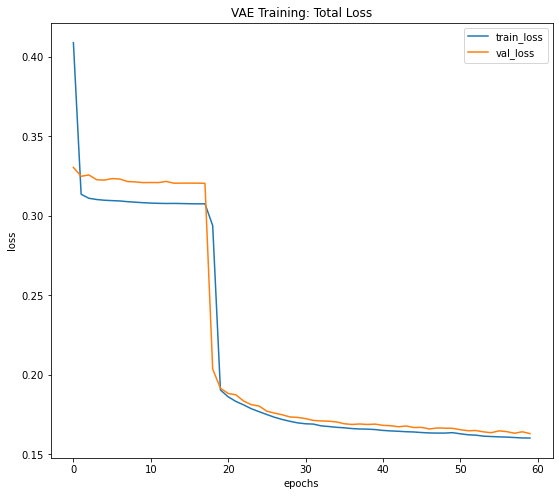

In [58]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_loss'] for e in train_history.keys()], label = 'train_loss')
plt.plot([train_history[e]['val_loss'] for e in train_history.keys()], label = 'val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Total Loss")
plt.show()

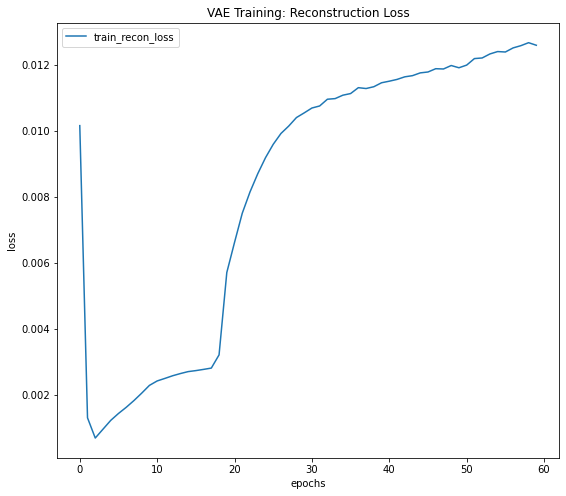

In [59]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_recon_loss'] for e in train_history.keys()], label = 'train_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

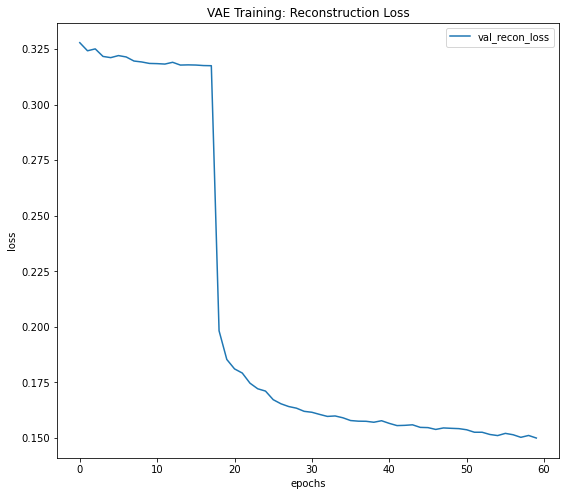

In [60]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['val_recon_loss'] for e in train_history.keys()], label = 'val_recon_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: Reconstruction Loss")
plt.show()

_Reconstruction loss_ has 2 plots since training and validation losses are on different scales.

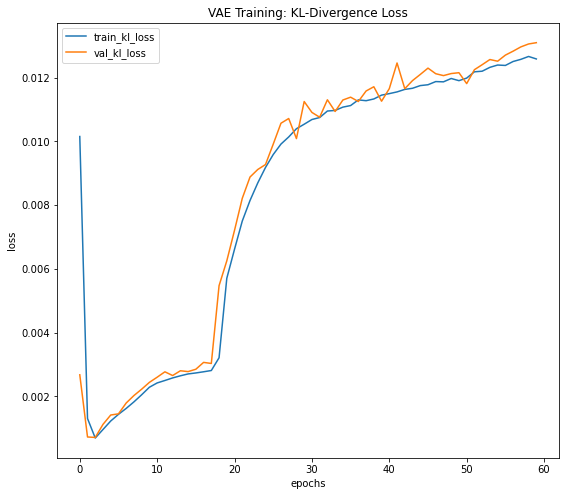

In [61]:
plt.figure(figsize = (9, 8))
plt.plot([train_history[e]['train_kl_loss'] for e in train_history.keys()], label = 'train_kl_loss')
plt.plot([train_history[e]['val_kl_loss'] for e in train_history.keys()], label = 'val_kl_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("VAE Training: KL-Divergence Loss")
plt.show()

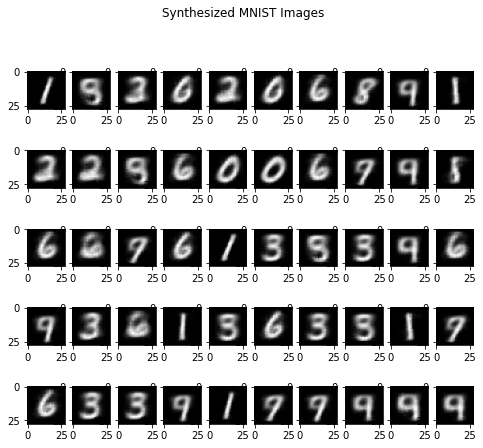

In [66]:
# Visualize 50 images from training set-
plt.figure(figsize = (8, 7))
for i in range(50):
    # 5 rows and 10 columns-
    plt.subplot(5, 10, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    plt.imshow(synthesized_images[i], cmap = 'gray')

plt.suptitle("Synthesized MNIST Images")
plt.show()

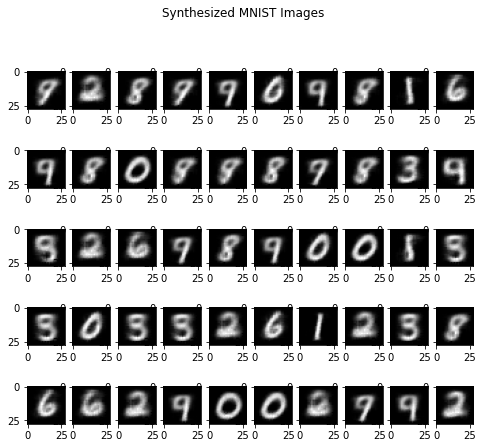

In [67]:
# Visualize 50 images from training set-
plt.figure(figsize = (8, 7))
for i in range(50):
    # 5 rows and 10 columns-
    plt.subplot(5, 10, i + 1)
    plt.imshow(synthesized_images[i + 5000], cmap = 'gray')

plt.suptitle("Synthesized MNIST Images")
plt.show()

### Visualize _mu_ & _log_var_ trained vectors

In [215]:
import plotly
import plotly.express as px

In [ ]:
# Visualize latent space for 'mu' vector-
fig = px.scatter_3d(
    x = mu[:, 0], y = mu[:, 1],
    z = mu[:, 2],
    # color = y_train
    )
fig.show()

In [ ]:
# Visualize latent space for 'log variance' vector-
fig = px.scatter_3d(
    x = log_var[:, 0], y = log_var[:, 1],
    z = log_var[:, 2],
    # color = y_train
    )
fig.show()

In [217]:
print(f"Mean vector (mu): mean = {mu.mean():4f} & std dev = {mu.std():.4f}")

Mean vector (mu): mean = -0.008894 & std dev = 0.8598


In [218]:
print(f"log-variance (log-var): mean = {log_var.mean():.4f} & std dev = {log_var.std():.4f}")

log-variance (log-var): mean = -3.4641 & std dev = 2.5549


In [204]:
np.sum(mu, axis = 0)

array([-1483.6248  ,    20.069199,  -137.35129 ], dtype=float32)

In [205]:
np.sum(log_var, axis = 0)

array([-2.7039500e+05,  3.3001474e+02, -3.5346928e+05], dtype=float32)

In [ ]:
for i in range(3):
    print(f"lv = {i + 1}: mean = {train_recon[:, i].mean():.4f} & std dev ="
          f" {train_recon[:, i].std():.4f}"
         )